In [2]:
from pprint import pprint 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as mtp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot
from matplotlib.colors import ListedColormap
from sklearn import linear_model
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [46]:
# Cleaning the data by looking at any empty values in the row and converting categorical data to numerical data
def clean_data(dataset):

    # Remove any data fields that are significantly underrepresented
    num_rows = len(dataset)
    remove_data_fields = []
    for column in dataset:
        null_count = dataset[column].isna().sum()
        if (null_count >= num_rows / 2):
            remove_data_fields.append(column)
    print(f"Removed data fields: {remove_data_fields}")
    dataset.drop(remove_data_fields)

    # Replace nulls with mean or something equally logical
    check = []
    check.append(len(dataset))
    dataset = dataset.dropna()
    check.append(len(dataset))
    print(f"Before: {check[0]} After: {check[1]}")
    check.clear()

    # Replace categorical variables with dummy variables
    dataset = to_numerical(dataset)

    mean_of_cols = {column: np.mean(dataset[column]) for column in dataset.columns}
    sd_of_cols = {column: np.std(dataset[column]) for column in dataset.columns}
    num_cols = len(dataset.columns)
    to_remove = []
    # Remove / replace outliers
    # Method 1: Removing rows that have more outliers than half the amount of columns or otherwise replacing outliers with the mean value of the column
    # In this method, we define outliers as data values that are 3 standard deviations away from the mean
    def outlier_1(dataset): 
        for index, row in dataset.iterrows():
            outliers = []
            for column in dataset.columns:
                data_mean, data_std = mean_of_cols[column], sd_of_cols[column]
                threshold = data_std * 3
                lower_bound, upper_bound = data_mean - threshold, data_mean + threshold
                if (row[column] <= lower_bound or row[column] >= upper_bound):
                    outliers.append(column)
            if len(outliers) == 0:
                continue
            elif len(outliers) > num_cols / 2:
                to_remove.append(dataset["customerID"])
            else:
                for cols in outliers:
                    dataset.iloc[index][cols] = mean_of_cols[cols]
        for id in to_remove:
            dataset = dataset[dataset.CustomerID != id]

    # Method 2: One-class classification
    # Removing all rows with outliers identified in the algorithm 
    def outlier_2(dataset, values):
        x, y = values[1:, :-1], values[1:, -1]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
        lof = LocalOutlierFactor()
        yhat = lof.fit_predict(x_train)
        mask = [i for i in range(len(yhat)) if yhat[i] == -1]
        dataset.drop(mask, axis=0, inplace=True)


    outlier_2(dataset, dataset.values)

    # Feature scaling: Standardisation
    scaler = StandardScaler()
    dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns, index=dataset.index)


    # Detecting correlations between independent variables
    matrix = dataset.corr().round(1)
    #sns.heatmap(matrix, annot=True)
    print(matrix.isin([i / 10 for i in range(7, 10)]).any())



    return dataset

def to_numerical(dataset):
    for i in list(dataset.columns):
        if not str((dataset[i]).head(1)).isnumeric():
            ord_enc = OrdinalEncoder() 
            dataset[i] = ord_enc.fit_transform(dataset[[i]])
    return dataset
    
# Open all the datasets 
transaction_data = pd.DataFrame(pd.read_csv("Data/telco_customer.csv", encoding="unicode_escape"))
#print((transaction_data['gender'].head(1)))
transaction_data = clean_data(transaction_data)
sns.regplot(x=transaction_data.MonthlyCharges,y=transaction_data.Churn, data=transaction_data, logistic=True, ci=None)


Removed data fields: []
Before: 7043 After: 7043


TypeError: 'float' object cannot be interpreted as an integer

In [8]:
# Testing for multicollinearity
num_cols = len(transaction_data.columns)
model_string = ' + '.join([transaction_data.columns[i] for i in range(1, num_cols - 1)])
y, x = dmatrices(f'Churn ~ {model_string}', data=transaction_data, return_type = 'dataframe')
vif_df = pd.DataFrame()
vif_df['variable'] = x.columns
vif_df['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
print(vif_df)

            variable        VIF
0          Intercept  23.312980
1             gender   1.001669
2      SeniorCitizen   1.149561
3            Partner   1.460845
4         Dependents   1.382153
5             tenure   2.754638
6       PhoneService   1.595437
7      MultipleLines   1.404471
8    InternetService   1.644109
9     OnlineSecurity   1.247164
10      OnlineBackup   1.188771
11  DeviceProtection   1.283092
12       TechSupport   1.302967
13       StreamingTV   1.462413
14   StreamingMovies   1.460232
15          Contract   2.479255
16  PaperlessBilling   1.202181
17     PaymentMethod   1.180566
18    MonthlyCharges   2.780474
19      TotalCharges   1.112663


<class 'sklearn.feature_selection._univariate_selection.SelectKBest'>
Feature: (0, 0.6277233214398283)
Feature: (1, 4.111832706905982e-26)
Feature: (2, 1.119699863372196e-22)
Feature: (3, 1.8257897722548714e-25)
Feature: (4, 7.597825526519917e-134)
Feature: (5, 0.1778770381339077)
Feature: (6, 0.00495401155861362)
Feature: (7, 0.0012807334613249043)
Feature: (8, 2.4543463438765066e-85)
Feature: (9, 3.4703311040869097e-41)
Feature: (10, 1.1208741211715148e-33)
Feature: (11, 2.854637730415469e-81)
Feature: (12, 0.01542420482017236)
Feature: (13, 0.025802626191808644)
Feature: (14, 1.8668368375148608e-172)
Feature: (15, 1.8809901216950583e-35)
Feature: (16, 1.4920309554489683e-12)
Feature: (17, 5.4568275491947935e-37)
Feature: (18, 0.4736188457131235)


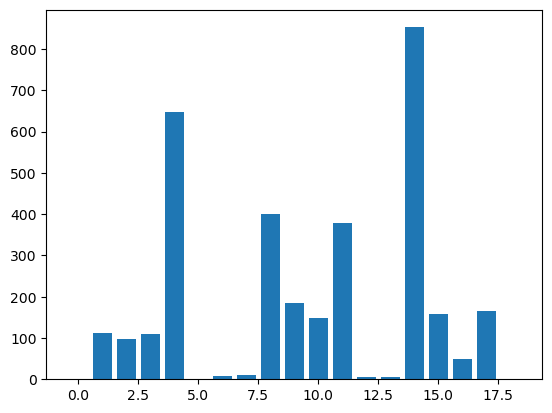

{'Contract': 15,
 'Dependents': 4,
 'DeviceProtection': 11,
 'InternetService': 8,
 'MonthlyCharges': 18,
 'MultipleLines': 7,
 'OnlineBackup': 10,
 'OnlineSecurity': 9,
 'PaperlessBilling': 16,
 'Partner': 3,
 'PaymentMethod': 17,
 'SeniorCitizen': 2,
 'StreamingMovies': 14,
 'StreamingTV': 13,
 'TechSupport': 12,
 'tenure': 5}


In [90]:
# Checking which variables are significant
def select_features(x_train, y_train, x_test):
    bestfeatures = SelectKBest(score_func = f_classif, k = 'all')
    bestfeatures.fit(x_train, y_train)
    x_train_fs = bestfeatures.transform(x_train)
    x_test_fs = bestfeatures.transform(x_test)
    return x_train_fs, x_test_fs, bestfeatures

x = transaction_data.iloc[:, [i for i in range(1, num_cols - 1)]]
y = transaction_data.iloc[:, num_cols - 1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
x_train_fs, x_test_fs, bestfeatures = select_features(x_train, y_train, x_test)
print(type(bestfeatures))
significant = {}
for i in range(len(bestfeatures.scores_)):
    if (bestfeatures.pvalues_[i] <= 0.05):
        significant.update({x.columns[i]: i + 1}) 
    print(f"Feature: {i, bestfeatures.pvalues_[i]}")
pyplot.bar([i for i in range(len(bestfeatures.scores_))], bestfeatures.scores_)
pyplot.show()
pprint(significant)

In [92]:
# Collecting the variables
x = transaction_data.iloc[:, [i for i in significant.values()]]
y = transaction_data.iloc[:, num_cols - 1]
print(x.head(5))
print(y.head(5))

   SeniorCitizen  Partner  Dependents  tenure  MultipleLines  InternetService  \
0            0.0      1.0         0.0     1.0            1.0              0.0   
1            0.0      0.0         0.0    34.0            0.0              0.0   
2            0.0      0.0         0.0     2.0            0.0              0.0   
3            0.0      0.0         0.0    45.0            1.0              0.0   
4            0.0      0.0         0.0     2.0            0.0              1.0   

   OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
0             0.0           2.0               0.0          0.0          0.0   
1             2.0           0.0               2.0          0.0          0.0   
2             2.0           2.0               0.0          0.0          0.0   
3             2.0           0.0               2.0          2.0          0.0   
4             0.0           0.0               0.0          0.0          0.0   

   StreamingMovies  Contract  Paperles

In [42]:
# Splitting the dataset into training and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

In [43]:
st_x = StandardScaler()
x_train = st_x.fit_transform(x_train)
x_test = st_x.transform(x_test)
#print(x_train.head(5))
#print(x_test.head(5))

In [44]:
classifier = LogisticRegression(random_state=0)
classifier.fit(x_train, y_train)


LogisticRegression(random_state=0)

In [45]:
y_pred= classifier.predict(x_test)
print(y_pred[:10])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [62]:
cm = confusion_matrix(y_test, y_pred)
cm
accuracy = (cm[0][1] + cm[1][0]) / (cm[0][0] + cm[1][1]) 
print(f"The accuracy of the predicted results is {1 - accuracy}")

The accuracy of the predicted results is 0.0816993464052288%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


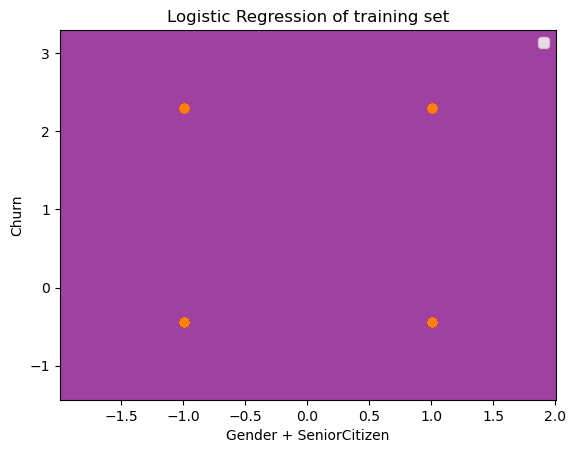

In [59]:
x_set, y_set = x_train , y_train
x1, x2 = np.meshgrid(np.arange(start = x_set[:, 0].min() - 1, stop = x_set[:, 0].max() + 1, step = 0.01), np.arange(start = x_set[:, 1].min() - 1, stop = x_set[:, 1].max() + 1, step = 0.01))
mtp.contourf(x1, x2, classifier.predict(np.array([x1.ravel(), x2.ravel()]).T).reshape(x1.shape), alpha = 0.75, cmap = ListedColormap(('purple', 'green')))
mtp.xlim(x1.min(), x1.max())
mtp.ylim(x2.min(), x2.max())
for i, j in enumerate(np.unique(y_set)):
    mtp.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1])
    c = ListedColormap('purple', 'green')(i)
mtp.title('Logistic Regression of training set')
mtp.xlabel('Gender + SeniorCitizen')
mtp.ylabel('Churn')
mtp.legend()
mtp.show()

